In [118]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from shapely.geometry import Point
from scipy.spatial import KDTree

In [119]:
directorio = os.path.dirname(os.getcwd())

In [120]:
baches = gpd.read_file(directorio + '/data/processed/tidy_baches_agebs_hmo.shp')
baches.CVEGEO = baches.CVEGEO.str[-4:]
se_ageb = gpd.read_file(directorio + '/data/processed/tidy_socioeconimico_ageb_hermosillo.shp')
se = pd.read_csv(directorio + '/data/processed/tidy_socioeconomico_hermosillo.csv')

In [121]:
baches = baches.dropna()

In [122]:
# Convertir a un sistema de referencia proyectado (metros) para medir distancias
gdf = baches.to_crs("EPSG:3857")

# Extraer las coordenadas de los puntos en metros
coordinates = [(geom.x, geom.y) for geom in gdf.geometry]

# Crear un KDTree con las coordenadas para encontrar vecinos cercanos
tree = KDTree(coordinates)
processed_indices = set()
new_data = []

# Recorrer cada punto en el GeoDataFrame
for i, point in enumerate(coordinates):
    if i in processed_indices:
        continue
    
    # Encontrar puntos dentro de un radio de 2 metros
    indices = tree.query_ball_point(point, r=2)
    processed_indices.update(indices)
    
    # Filtrar el GeoDataFrame original para estos índices
    close_points = gdf.iloc[indices]
    
    # Obtener el punto medio de las coordenadas
    mean_x = close_points.geometry.x.mean()
    mean_y = close_points.geometry.y.mean()
    mean_point = Point(mean_x, mean_y)
    
    # Obtener la fecha más antigua y un ageb al azar
    oldest_date = close_points['date'].min()
    random_ageb = close_points['CVEGEO'].sample(1).iloc[0]  # Elegir un `ageb` al azar si hay varios
    
    # Guardar el resultado en una lista
    new_data.append({
        "date": oldest_date,
        "CVEGEO": random_ageb,
        "geometry": mean_point
    })

# Crear un nuevo GeoDataFrame con los resultados
new_gdf = gpd.GeoDataFrame(new_data, geometry="geometry", crs="EPSG:3857")

# Opcional: Convertir de nuevo a EPSG:4326 si necesitas las coordenadas originales
new_gdf = new_gdf.to_crs("EPSG:4326")


In [123]:
baches = new_gdf

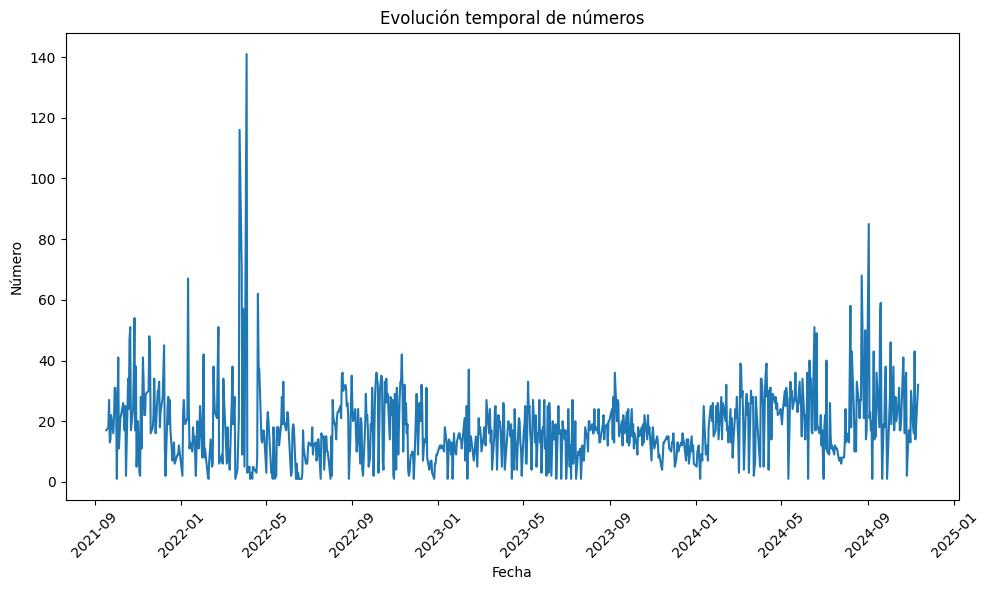

In [124]:
baches_por_fecha = baches.groupby('date',as_index=False).size()

plt.figure(figsize=(10, 6))
plt.plot(baches_por_fecha['date'], baches_por_fecha['size'])

# Configuración de etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Número")
plt.title("Evolución temporal de números")

# Rotar las etiquetas de las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

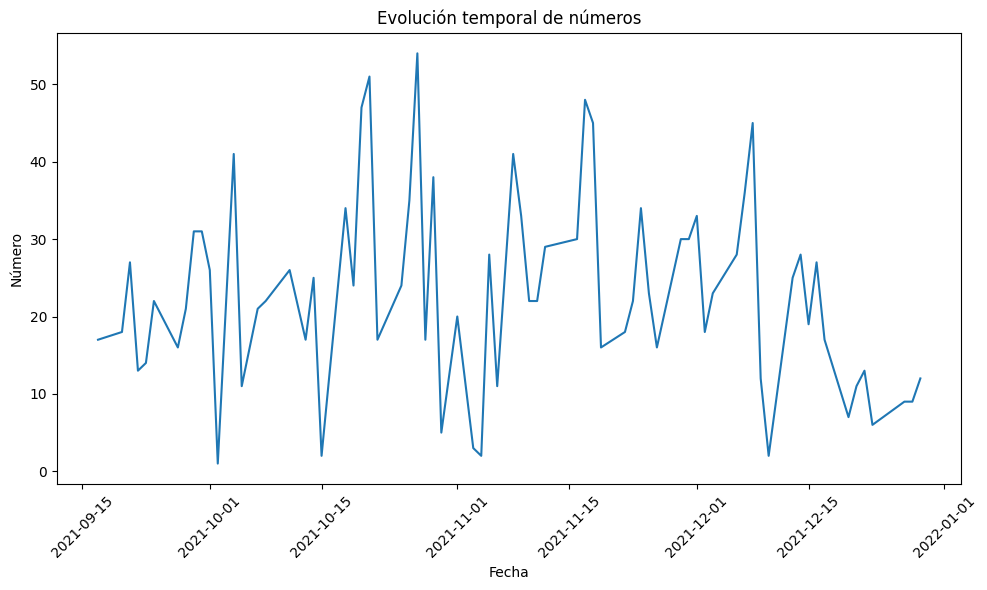

In [125]:
baches_por_fecha_2021 = baches_por_fecha[baches_por_fecha['date'].dt.year == 2021]

plt.figure(figsize=(10, 6))
plt.plot(baches_por_fecha_2021['date'], baches_por_fecha_2021['size'])

# Configuración de etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Número")
plt.title("Evolución temporal de números")

# Rotar las etiquetas de las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

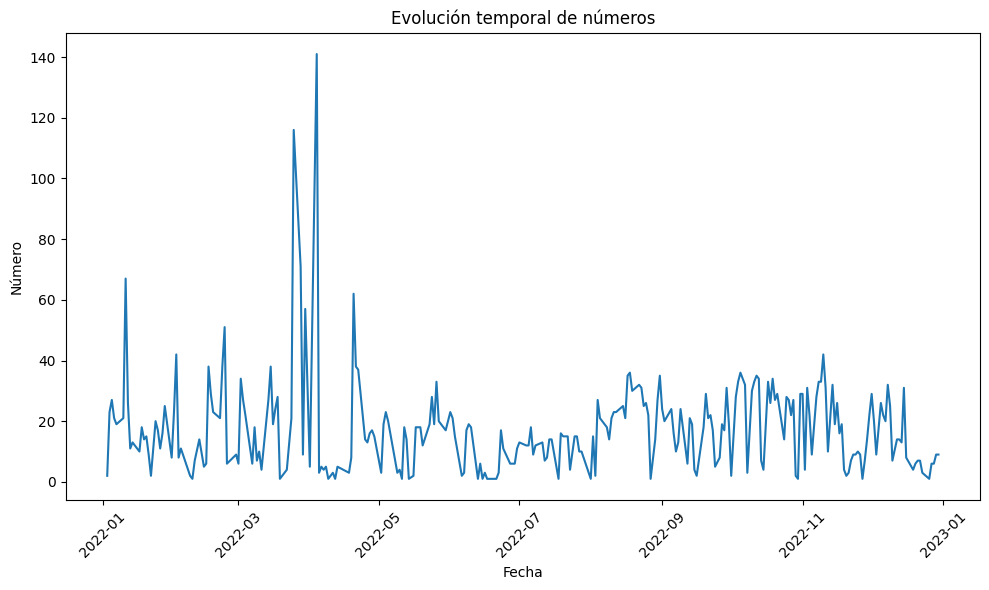

In [126]:
baches_por_fecha_2021 = baches_por_fecha[baches_por_fecha['date'].dt.year == 2022]

plt.figure(figsize=(10, 6))
plt.plot(baches_por_fecha_2021['date'], baches_por_fecha_2021['size'])

# Configuración de etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Número")
plt.title("Evolución temporal de números")

# Rotar las etiquetas de las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

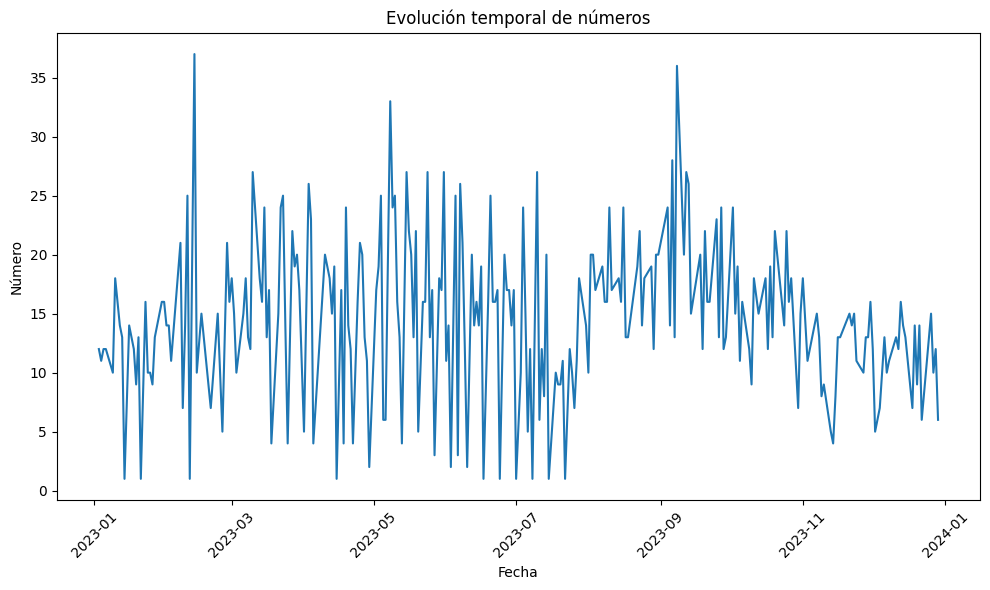

In [127]:
baches_por_fecha_2021 = baches_por_fecha[baches_por_fecha['date'].dt.year == 2023]

plt.figure(figsize=(10, 6))
plt.plot(baches_por_fecha_2021['date'], baches_por_fecha_2021['size'])

# Configuración de etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Número")
plt.title("Evolución temporal de números")

# Rotar las etiquetas de las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

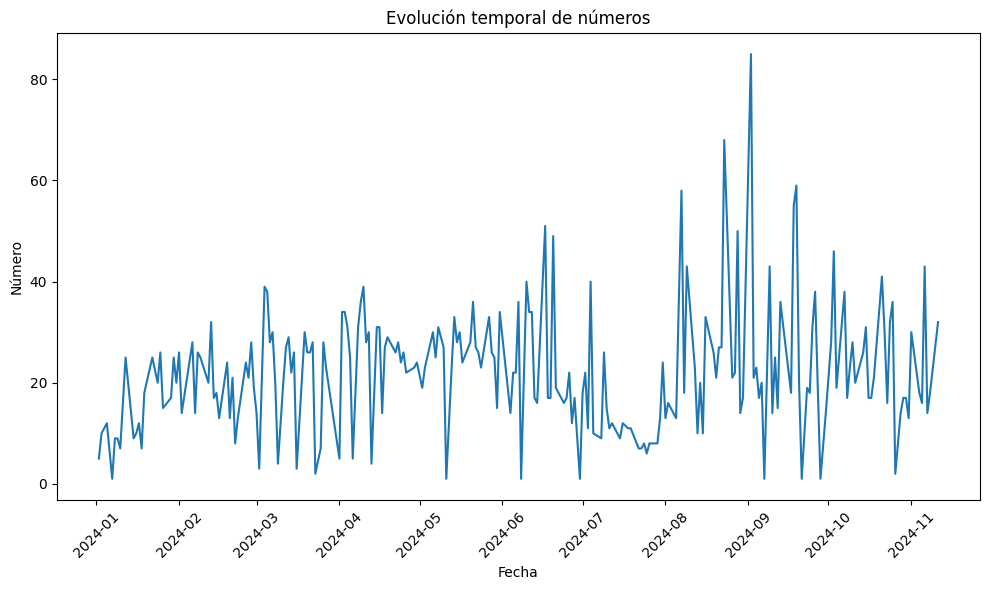

In [128]:
baches_por_fecha_2021 = baches_por_fecha[baches_por_fecha['date'].dt.year == 2024]

plt.figure(figsize=(10, 6))
plt.plot(baches_por_fecha_2021['date'], baches_por_fecha_2021['size'])

# Configuración de etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Número")
plt.title("Evolución temporal de números")

# Rotar las etiquetas de las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [129]:
fechas_importantes = baches_por_fecha.sort_values(by='size' \
                                                ,ascending=False)['date'].head(1).to_list()

In [130]:
baches = baches.to_crs('EPSG:4326')

/tmp/ipykernel_159844/490376176.py:6: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler



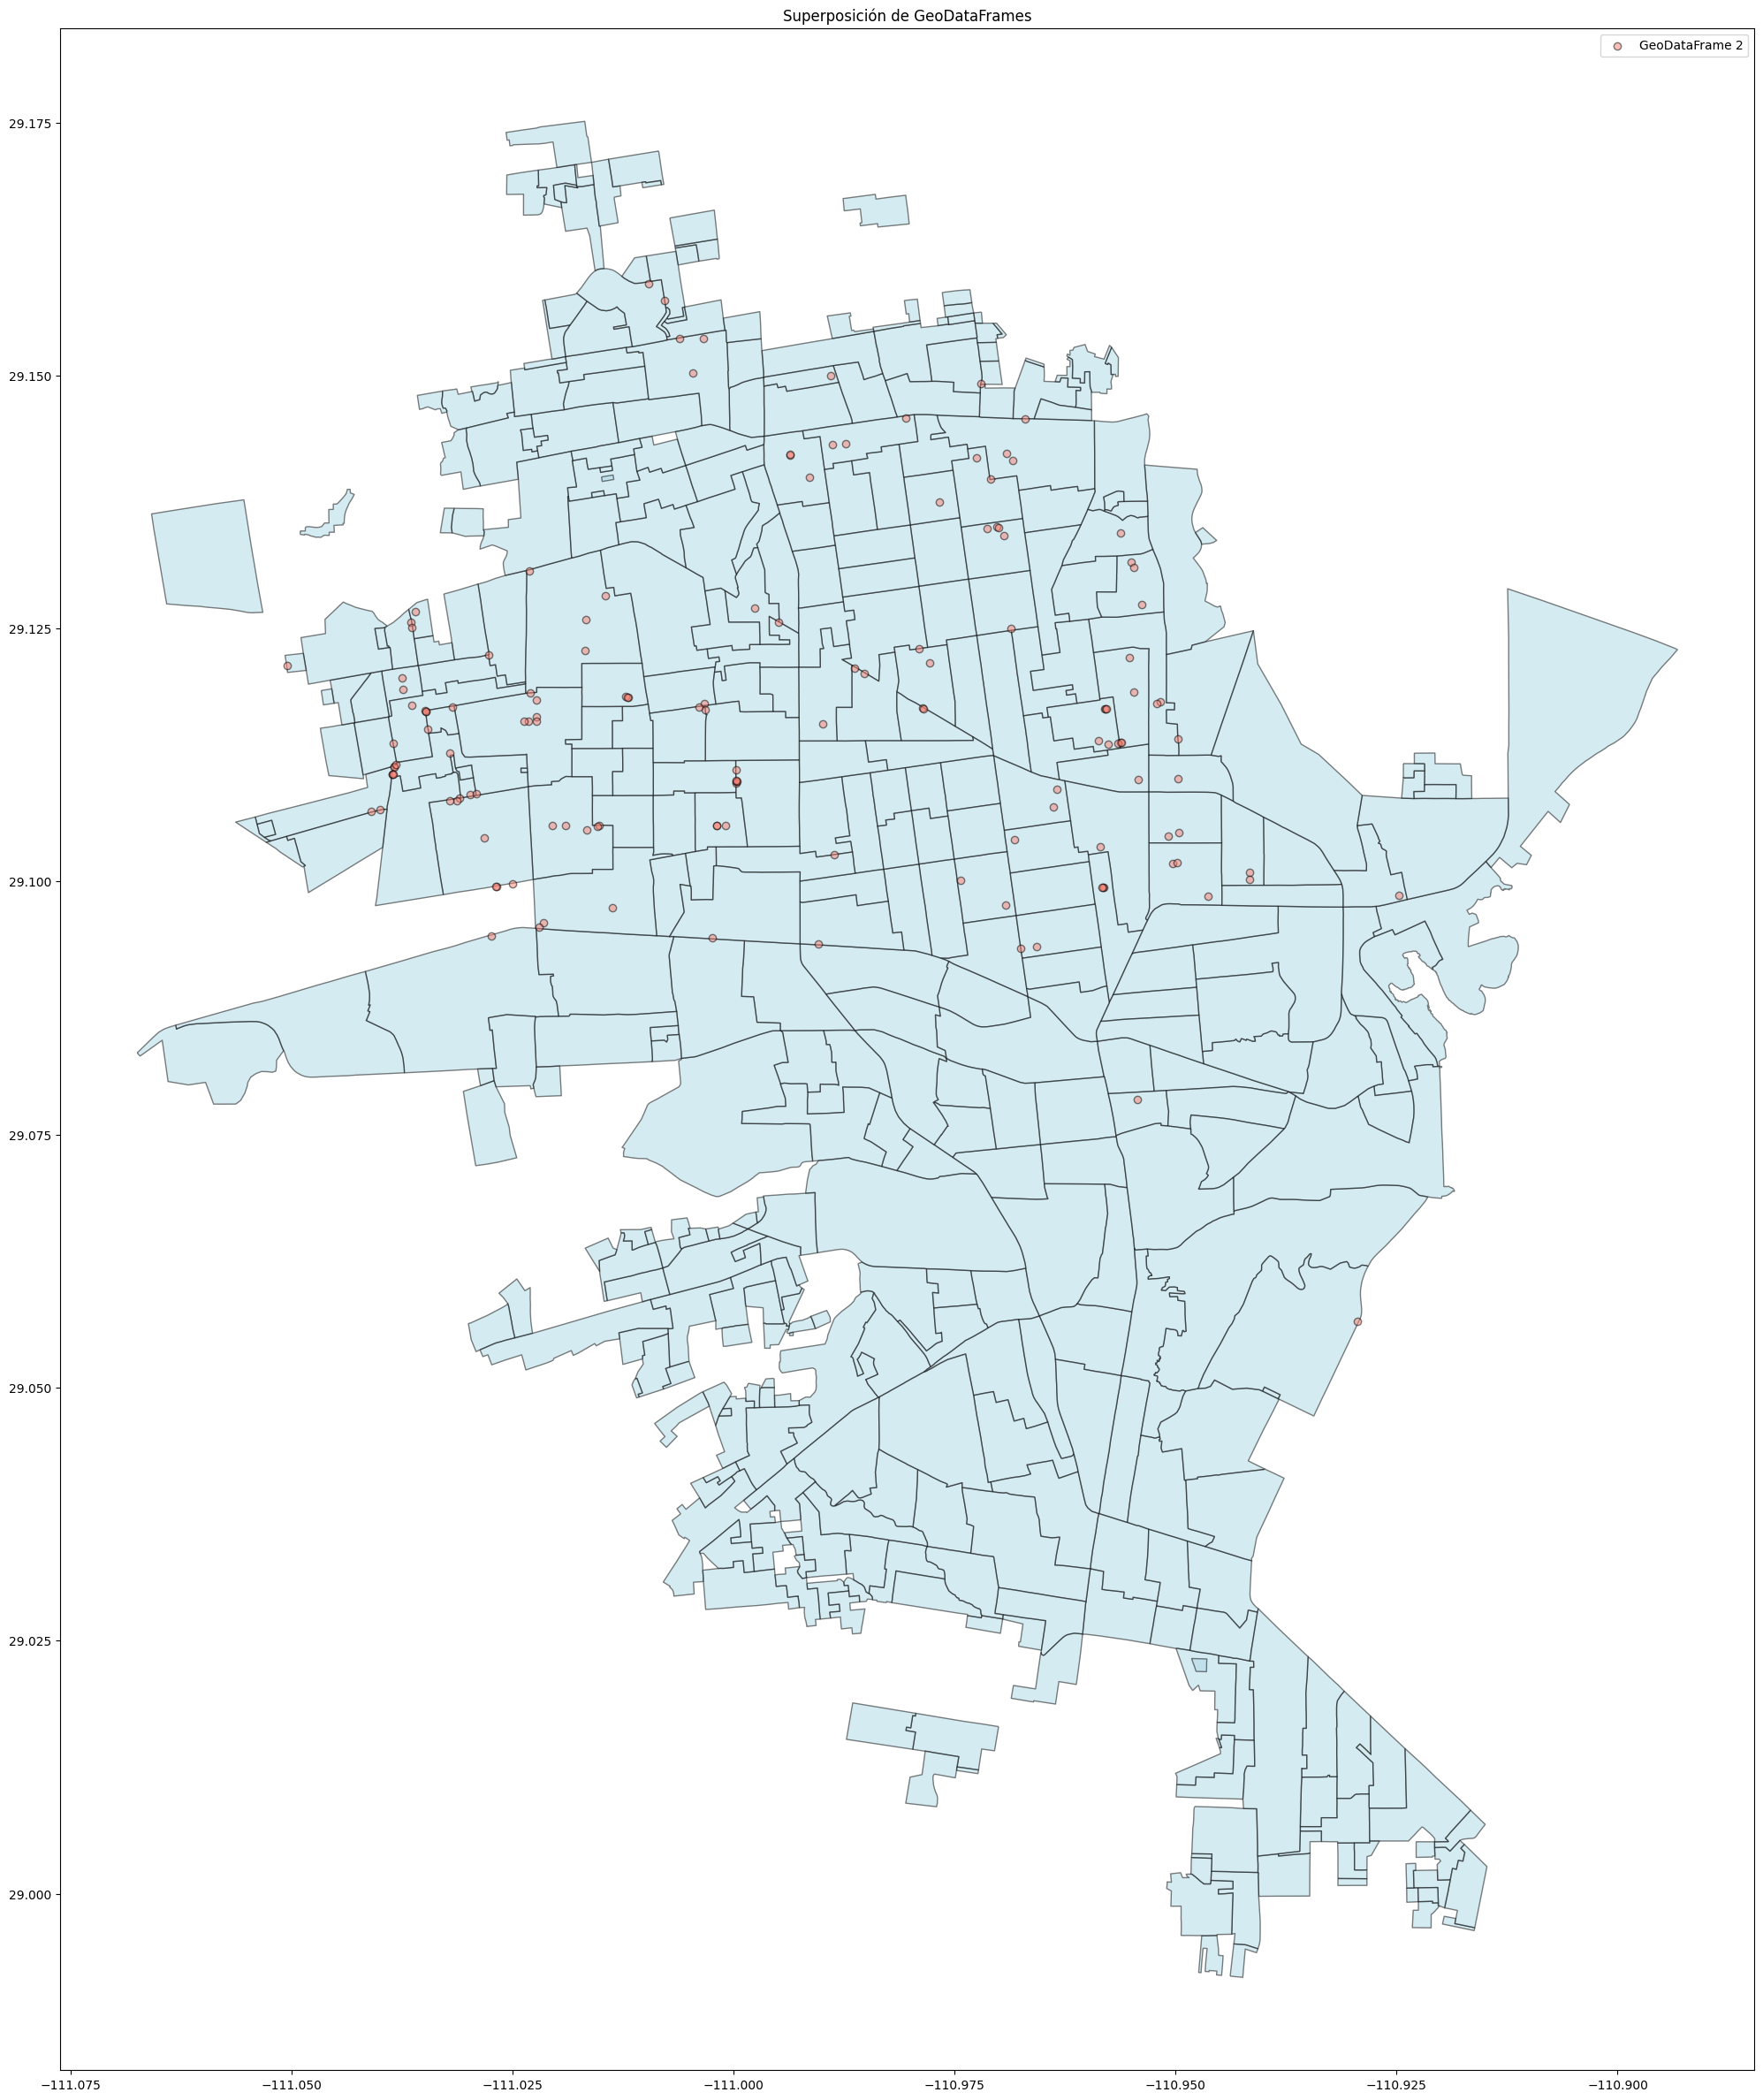

In [131]:
fig, ax = plt.subplots(figsize=(30,30))
se_ageb.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5, label="GeoDataFrame 1")
baches[baches.date.isin(fechas_importantes)].plot(ax=ax, color="salmon", edgecolor="black", alpha=0.5, label="GeoDataFrame 2")

# Agregar leyenda y título
plt.legend()
plt.title("Superposición de GeoDataFrames")
plt.show()

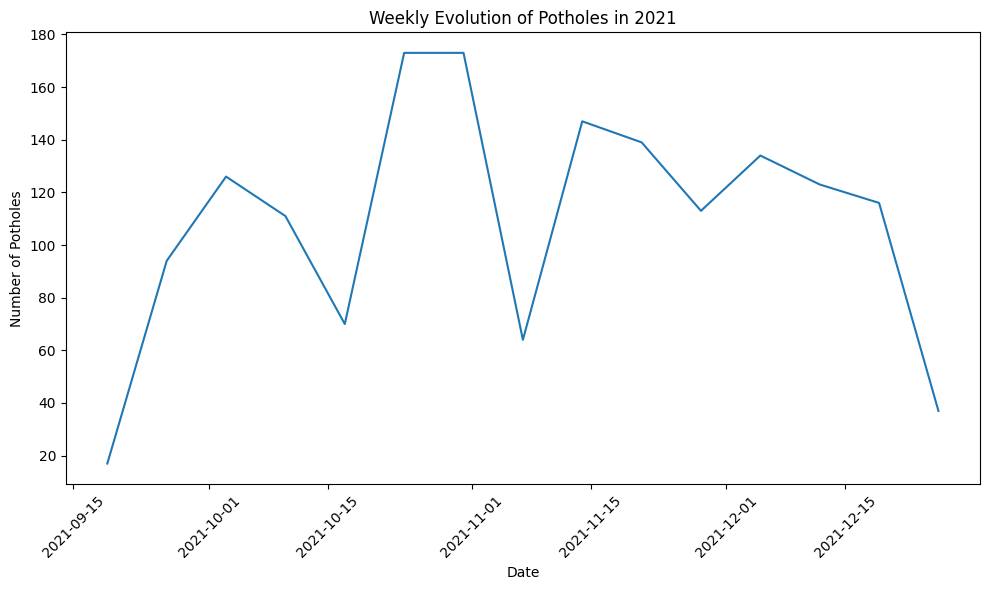

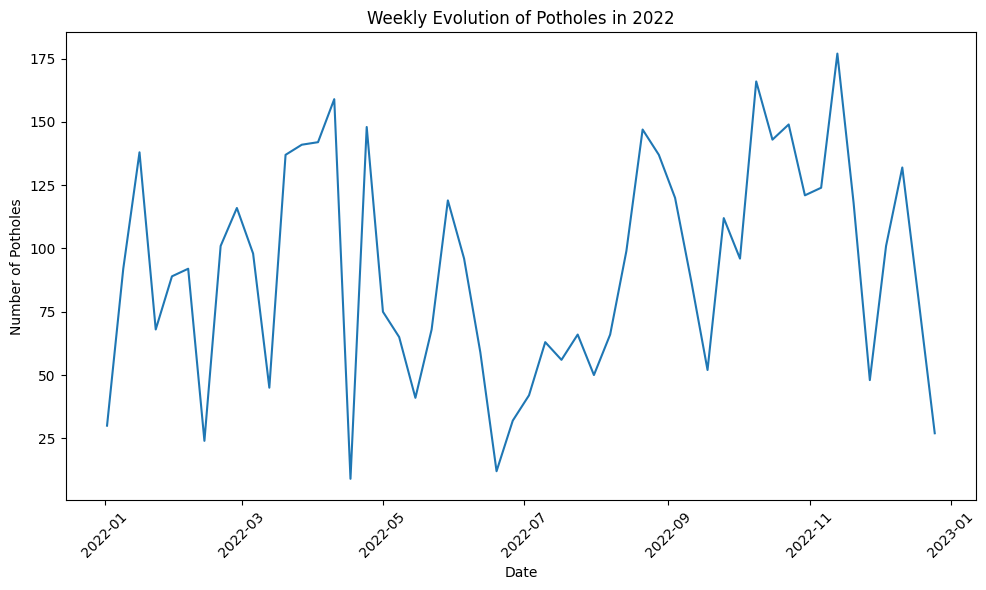

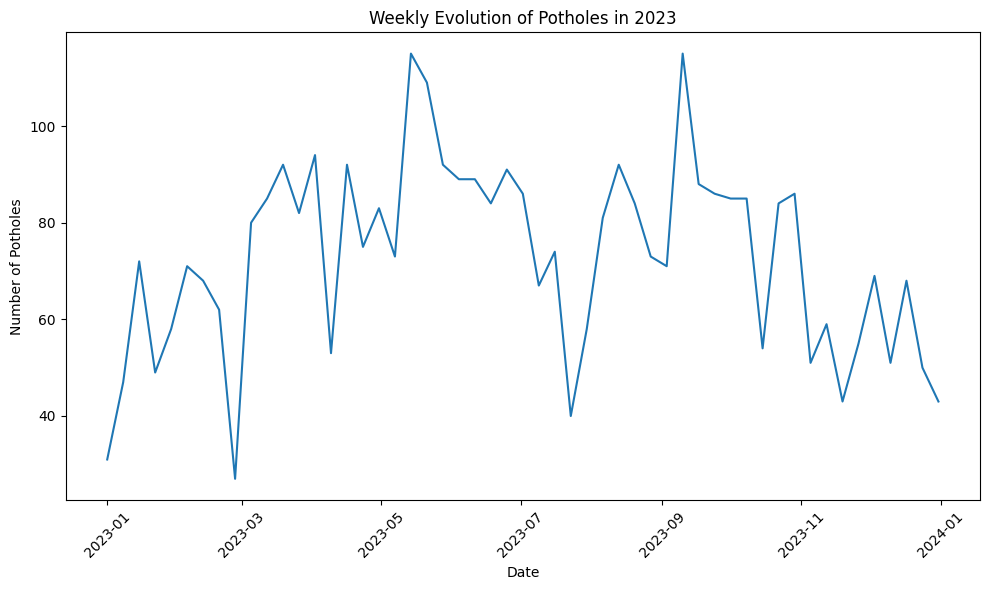

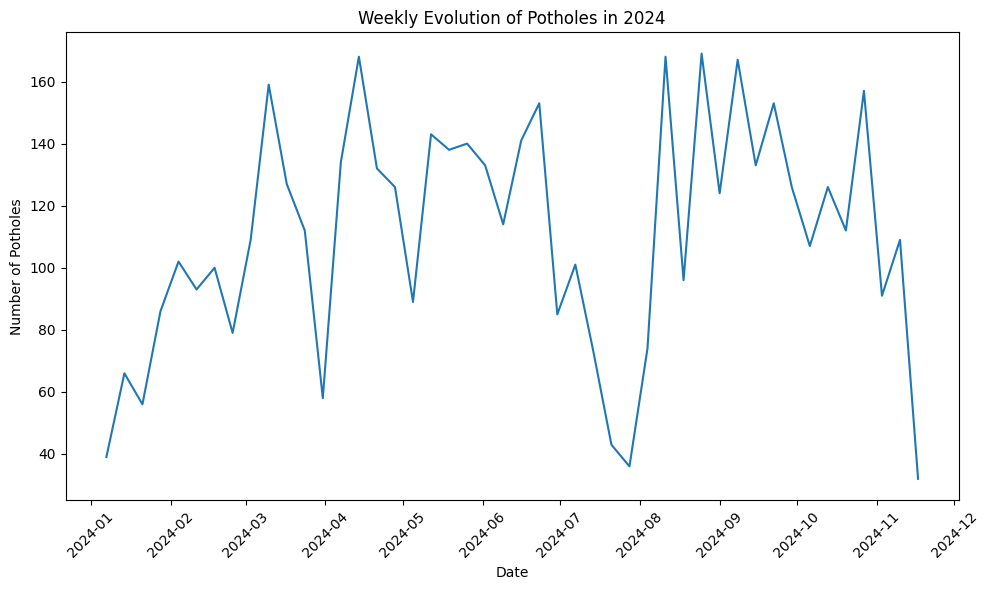

In [132]:
baches_por_fecha['date'] = pd.to_datetime(baches_por_fecha['date'])

for i in [2021, 2022, 2023, 2024]:
    # Group data by week and count the number of potholes
    baches_por_fecha_semana = baches_por_fecha.set_index('date').resample('W').sum().reset_index()

    # Filter the data for the specific year
    baches_por_fecha_semana_year = baches_por_fecha_semana[baches_por_fecha_semana['date'].dt.year == i]

    # Create the line plot with Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=baches_por_fecha_semana_year, x='date', y='size')

    # Set labels and title
    plt.xlabel("Date")
    plt.ylabel("Number of Potholes")
    plt.title(f"Weekly Evolution of Potholes in {i}")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

<Figure size 2000x2000 with 0 Axes>

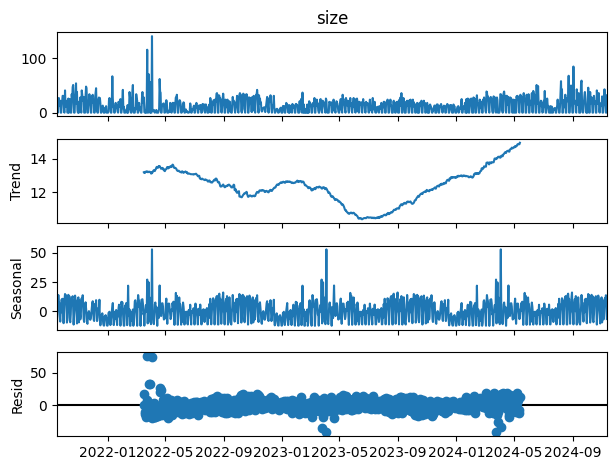

In [133]:
baches_por_fecha = baches_por_fecha.reset_index()
baches_por_fecha.set_index('date', inplace=True)

# Opcional: Asegurarse de tener los datos agregados por día (si los datos son más granulares)
df = baches_por_fecha.resample('D').sum()  # Cambia 'D' a 'M' si quieres ver datos mensuales

# Descomposición estacional con un período de 365 días para capturar patrones anuales
result = seasonal_decompose(df['size'], model='additive', period=365)
plt.figure(figsize=(20,20))
# Graficar los resultados
result.plot()
plt.show()

<Axes: xlabel='date'>

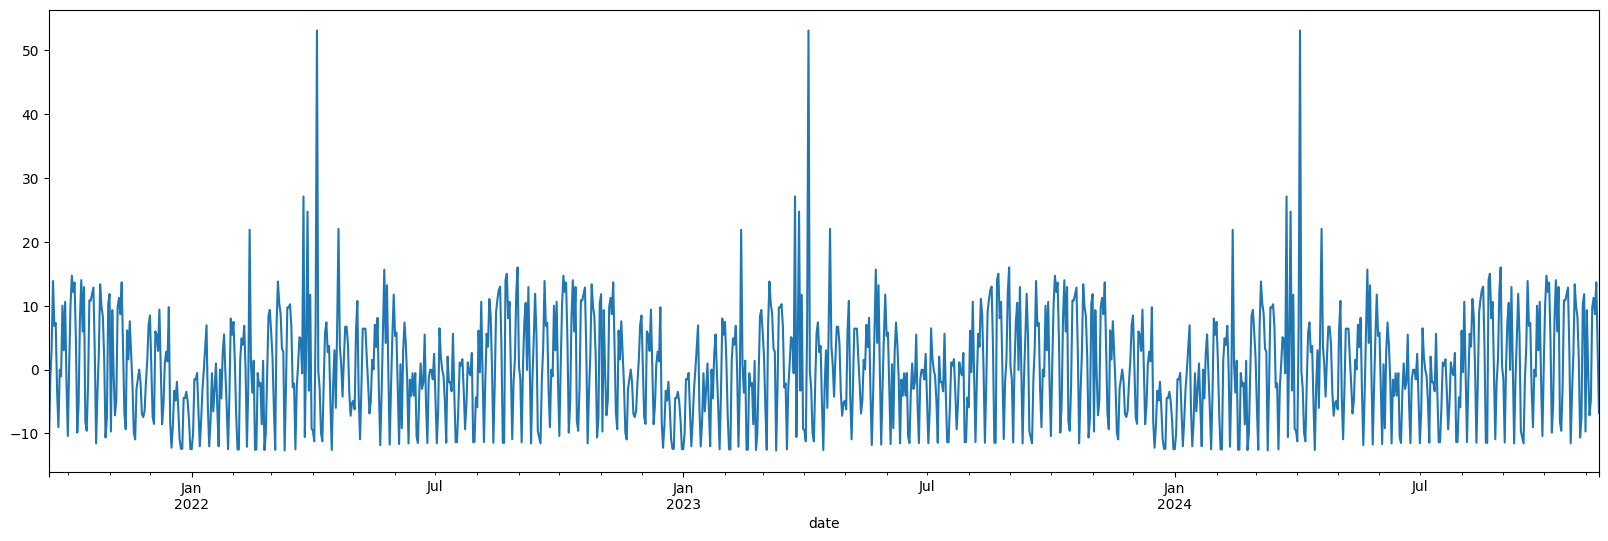

In [134]:
result.seasonal.plot(figsize=(20,6))

<Axes: xlabel='date'>

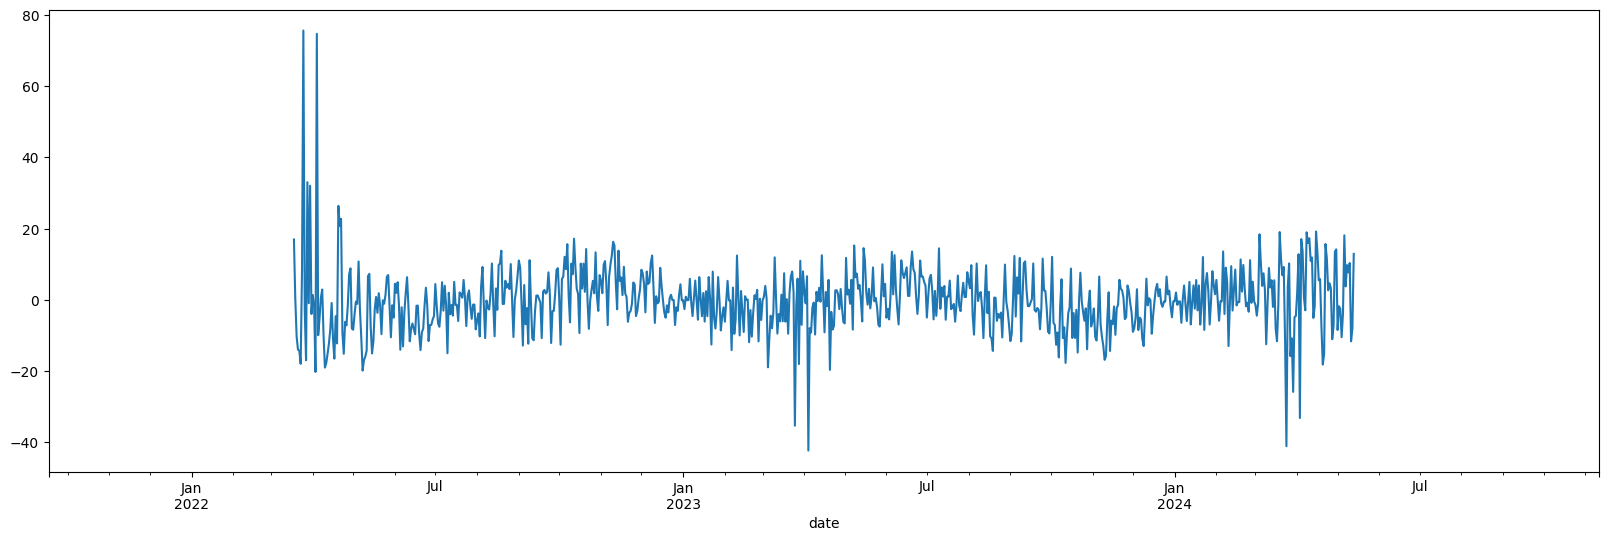

In [135]:
result.resid.plot(figsize=(20,6))

<Axes: xlabel='date'>

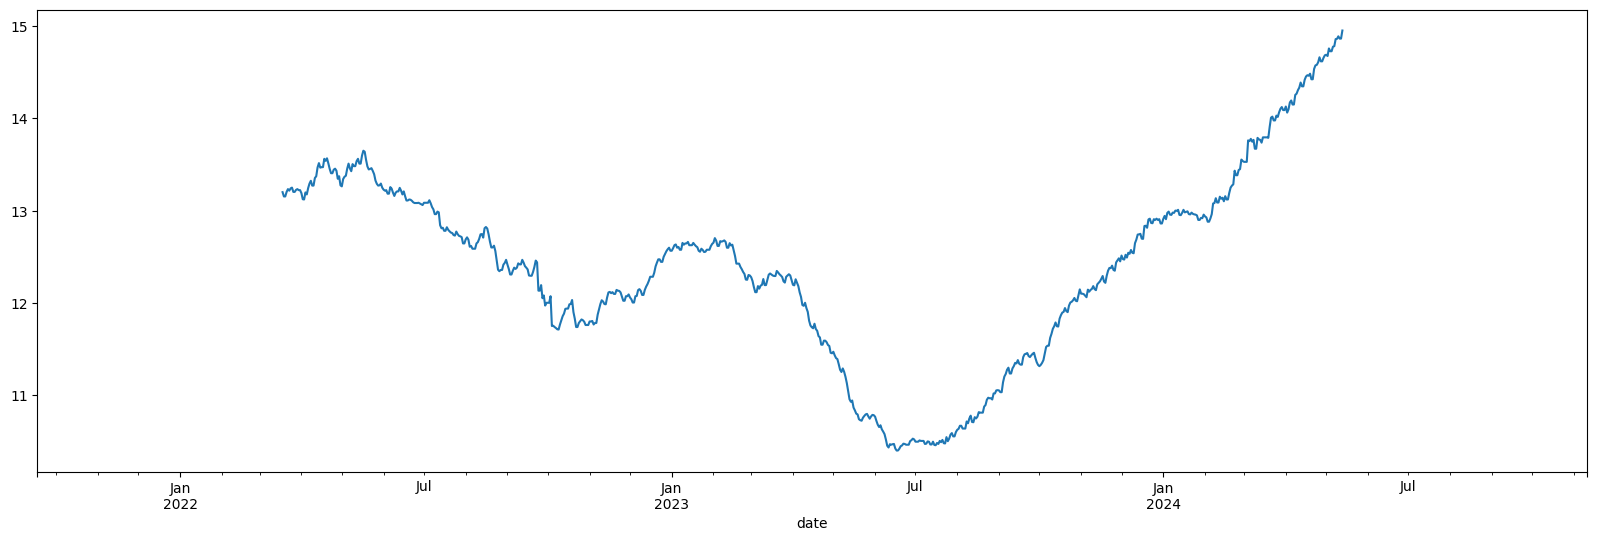

In [136]:
result.trend.plot(figsize=(20,6))

In [137]:
baches.head()

,date,CVEGEO,geometry
0,2021-10-18,1996,POINT (-110.96947 29.09416)
1,2021-10-19,1746,POINT (-110.97132 29.12406)
2,2021-10-19,1746,POINT (-110.97129 29.12399)
3,2021-10-21,5043,POINT (-110.95393 29.12878)
4,2021-10-04,2617,POINT (-111.0421 29.08381)


In [138]:
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px

df = baches.groupby('date',as_index=False).size()

fig = px.scatter(
    df,
    y="size"
).update_layout(
    title='Reporte de baches Hermosillo',
    hovermode="x"
).show()

In [139]:
df["ma 3"] = df['size'].rolling(window=3, center=False).mean()
df["ma 7"] = df['size'].rolling(window=7, center=False).mean()
df["ma 14"] = df['size'].rolling(window=14, center=False).mean()

fig = go.Figure(
).add_scatter(
    x=df.index,
    y=df["size"],
    mode='markers',
    name="Real"
).add_scatter(
    x=df.index,
    y=df["ma 3"],
    hovertemplate="%{y:.1f}",
    name="MA 3 días"
).add_scatter(
    x=df.index,    
    y=df["ma 7"],
    hovertemplate="%{y:.1f}",
    name="MA 7 días"
).add_scatter(
    x=df.index,
    y=df["ma 14"],
    hovertemplate="%{y:.1f}",
    name="MA 14 días"
).update_layout(
    title='Reporte de baches Hermosillo',
    #hovermode="x unified"
).show()

In [140]:
df["mm 3"] = df['size'].rolling(window=3, center=False).median()
df["mm 7"] = df['size'].rolling(window=7, center=False).median()
df["mm 14"] = df['size'].rolling(window=14, center=False).median()

fig = go.Figure(
).add_scatter(
    x=df.index,
    y=df["size"],
    mode='markers',
    name="Real"
).add_scatter(
    x=df.index,
    y=df["mm 3"],
    hovertemplate="%{y:.1f}",
    name="MM 3 días"
).add_scatter(
    x=df.index,    
    y=df["mm 7"],
    hovertemplate="%{y:.1f}",
    name="MM 7 días"
).add_scatter(
    x=df.index,
    y=df["mm 14"],
    hovertemplate="%{y:.1f}",
    name="MM 14 días"
).update_layout(
    title='Reporte de baches Hermosillo',
    hovermode="x"
).show()

In [141]:
lowess = sm.nonparametric.lowess

l1 = lowess(df["size"], df.index, frac=1/5)
l2 = lowess(df["size"], df.index, frac=1/10)
l3 = lowess(df["size"], df.index, frac=1/20)

fig = go.Figure(
).add_scatter(
    x=df.index,
    y=df["size"],
    mode='markers',
    name="Real"
).add_scatter(
    x=df.index[1:],
    y=l1[:,1],
    hovertemplate="%{y:.1f}",
    name="LOWESS 1/5"
).add_scatter(
    x=df.index[1:],    
    y=l2[:,1],
    hovertemplate="%{y:.1f}",
    name="LOWESS 1/10"
).add_scatter(
    x=df.index[1:],
    y=l3[:,1],
    hovertemplate="%{y:.1f}",
    name="LOWESS 1/20"
).update_layout(
    title='Reporte de baches Hermosillo',
    hovermode="x"
).show()

In [142]:
fig = go.Figure(
).add_scatter(
    x=df.index,
    y=df["size"],
    mode='markers',
    name="Real"
).add_scatter(
    x=df.index[1:],    
    y=l2[:,1],
    hovertemplate="%{y:.1f}",
    fill='tozeroy',
    name="Suaivizado (LOWESS)"
).update_layout(
    title='Reporte de baches Hermosillo',
    hovermode="x",
    showlegend=False
).show()

In [143]:
df.head()

,date,size,ma 3,ma 7,ma 14,mm 3,mm 7,mm 14
0,2021-09-17,17,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-20,18,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-21,27,20.666667,NaN,NaN,18.0,NaN,NaN
3,2021-09-22,13,19.333333,NaN,NaN,18.0,NaN,NaN
4,2021-09-23,14,18.000000,NaN,NaN,14.0,NaN,NaN


In [144]:
df['date'] = pd.to_datetime(df['date'])

# Extraer el mes y el año de la columna 'date'
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Agrupar por mes y año, y calcular el tamaño (puedes sustituir por el valor real que quieras analizar)
monthly_stats = df.groupby(['year', 'month'], as_index=False)['size'].sum()

# Ahora, calcular el promedio y la desviación estándar por mes, sin perder la información de cada mes
monthly_stats = monthly_stats.groupby('month')['size'].agg(['mean', 'std']).reset_index()

# Redondear el resultado a dos decimales
monthly_stats['mean'] = monthly_stats['mean'].round(2)
monthly_stats['std'] = monthly_stats['std'].round(2)

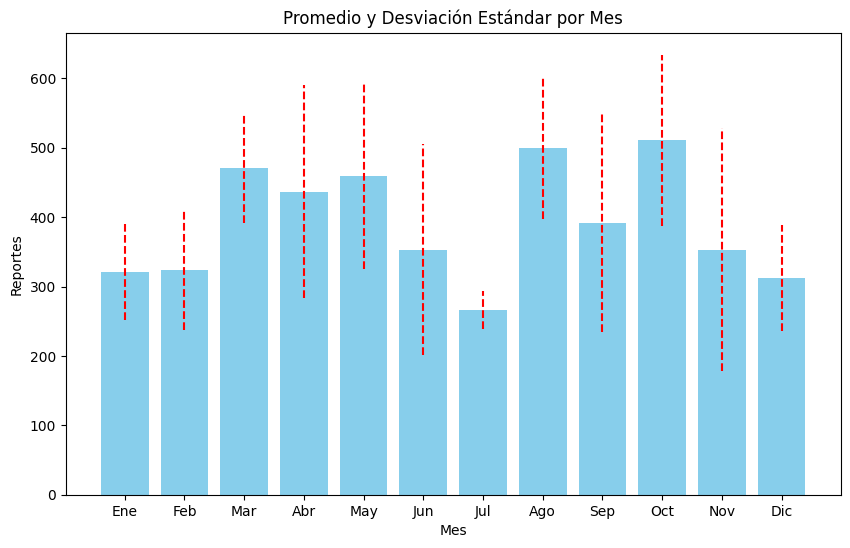

In [145]:
plt.figure(figsize=(10, 6))

# Dibujar las barras para la media
bars = plt.bar(monthly_stats['month'], monthly_stats['mean'], color='skyblue', label='Media')

# Agregar las líneas de desviación estándar
for i, bar in enumerate(bars):
    # Obtener la posición y altura de cada barra
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2  # El centro de la barra
    
    # Dibujar líneas para la media + desviación estándar y media - desviación estándar
    plt.plot([x, x], [height - monthly_stats['std'].iloc[i], height + monthly_stats['std'].iloc[i]], color='red', linestyle='--')

# Etiquetas
plt.xlabel('Mes')
plt.ylabel('Reportes')
plt.title('Promedio y Desviación Estándar por Mes')
plt.xticks(monthly_stats['month'], labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])


# Mostrar la gráfica
plt.show()